SOLO AÑADIR COSAS DEBAJO DEL CHUNK DE CADA NOMBRE

ESTA PARTE ES PARA JAVIER

# ESTA PARTE ES PARA ALMODOVAR

We are first going to updload all the data avaliable and try to understand it

In [1]:
import pandas as pd
import matplotlib as plt

data1=pd.read_csv("DATA/tripdata_2017-01.csv",header=0)
data2=pd.read_csv("DATA/tripdata_2017-02.csv",header=0)

serial_dataset=pd.concat([data1,data2])

print(serial_dataset.tail(10))

serial_dataset.columns.values
serial_dataset.shape

        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
971400         2  2017-02-03 19:53:21   2017-02-03 19:55:48                5   
971401         2  2017-02-03 19:53:21   2017-02-03 19:59:47                5   
971402         2  2017-02-03 19:53:21   2017-02-03 19:57:39                1   
971403         1  2017-02-03 19:53:22   2017-02-03 20:25:28                2   
971404         1  2017-02-03 19:53:22   2017-02-03 20:23:40                1   
971405         1  2017-02-03 19:53:22   2017-02-03 20:00:27                1   
971406         2  2017-02-03 19:53:22   2017-02-03 20:15:06                5   
971407         2  2017-02-03 19:53:22   2017-02-03 20:08:45                1   
971408         2  2017-02-03 19:53:22   2017-02-03 20:00:57                1   
971409         2  2017-02-03 19:53:22   2017-02-03 20:02:25                1   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
971400           0.61           1                

(1942420, 17)

In [2]:
serial_dataset['total_amount'].idxmax()


127949

# 3 - Type of payment in terms of different pick up zones

We are going to try first to do an analysisis that uses serial computation and basic libraries from python to analyse the mean price of travels for the different pick-up zones and payment methods.

We see that we have four levels for the payment method:

1 - Credit Card
2 - Cash
3 - No charge
4 - Dispute

<AxesSubplot:xlabel='DOLocationID'>

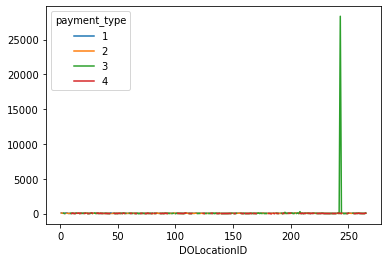

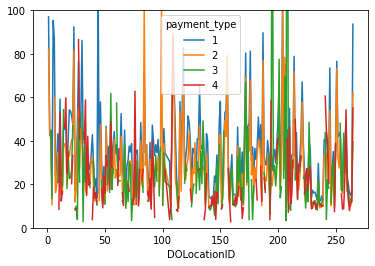

In [45]:
fourth_analysis=serial_dataset.loc[:,['DOLocationID','payment_type','total_amount']]
fourth_analysis.groupby(['DOLocationID','payment_type'])['total_amount'].mean().unstack().plot()

a=fourth_analysis.index[(fourth_analysis['total_amount']>1000) | (fourth_analysis['total_amount']<0)]
a
fourth_analysis=fourth_analysis.drop(a,axis=0)
fourth_analysis.groupby(['DOLocationID','payment_type'])['total_amount'].mean().unstack().plot(ylim=[0,100])


As we can see, in general, the payment method most used for the most expensive trips is isually by credit card. However there is also a lot of trips that are out of charge and that those trips with disputes to pay are for low amounts.

Now let's check what is the mean price for each payment method

payment_type
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: total_amount, dtype: object

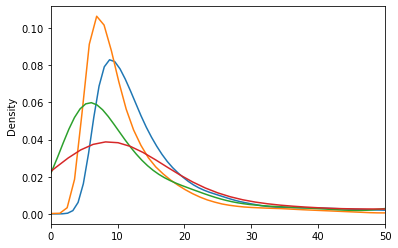

In [61]:
fourth_analysis.groupby(["payment_type"])["total_amount"].plot(kind='density',xlim=[0,50],xlabel="Price")

We can see that morarles the main payment price is concentrated over the same quantity, between 5 and 10 dollars. Nevertheless we can see that in general most payment method used is the cash and the mean value of trips is a little bit lower than the credit ones. 

# Analysis using SPARK

First of all we have to get the data. In contrast with what we did on the serial version, now we use a moethod from spark to get both datasets directly into 1 object. Using spark we are direcly creating an RDD object.

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("prueba").master("local[*]").getOrCreate()

spark_dataset = spark.read.option("header","true").csv("DATA/*.csv")

ESTA PARTE ES PARA ALBERTO